In [1]:
import json
import requests
import pandas as pd
import numpy as np
from itertools import chain
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

In [2]:
user = "marina"
pw = "testingfuji"
sparql_endpoint = "https://orkg.org/triplestore"
fuji_server = "http://localhost:1071/fuji/api/v1/evaluate"

In [3]:
def build_result_json(result):
    if result is None:
        return None
    res = []
    for r in result:
        r_dict = {}
        r_dict["metric"] = r.get("metric_identifier")
        r_dict["score_earned"] = r.get("score").get("earned")
        r_dict["score_total"] = r.get("score").get("total")
        res.append(r_dict)
    return res

In [4]:
def get_assessment(load):
    global count
    print(count)
    print(load)
    payload = {
        "metadata_service_endpoint": sparql_endpoint,
        "metadata_service_type": "sparql",
        "object_identifier": load,
        "test_debug": True,
        "use_datacite": True
    }
    response = requests.post(
        url = fuji_server,
        json = payload,
        auth = (user, pw)
    )
    result = build_result_json(response.json().get("results"))
    count = count + 1
    print("__________________________")
    return result

In [5]:
def get_principle_from_metric(metric):
    if metric.startswith("FsF-F"):
        return "findable"
    elif metric.startswith("FsF-A"):
        return "accessible"
    elif metric.startswith("FsF-I"):
        return "interoperable"
    else:
        return "reusable"

In [6]:
def get_metrics_from_result(assessment_result):
    return [item.get('metric') for item in assessment_result]

def get_earned_scores_from_result(assessment_result):
    return [int(item.get('score_earned')) for item in assessment_result]

def get_total_scores_from_result(assessment_result):
    return [int(item.get('score_total')) for item in assessment_result]

Metric descriptions as stated on https://www.f-uji.net/index.php:

Findable:
- FsF-F1-01D - Data is assigned a globally unique identifier.
    - FsF-F1-01D-1: Identifier is resolvable and follows a defined unique identifier syntax (IRI, URL)
    - FsF-F1-01D-2: Identifier is not resolvable but follows an UUID or HASH type syntax
- FsF-F1-02D - Data is assigned a persistent identifier
    - FsF-F1-02D-1: Identifier follows a defined persistent identifier syntax
    - FsF-F1-02D-2: Persistent identifier is resolvable
- FsF-F2-01M: Metadata includes descriptive core elements (creator, title, data identifier, publisher, publication date, summary and keywords) to support data findability.
    - FsF-F2-01M-1: Metadata has been made available via common web methods
    - a: Metadata is embedded in the landing page XHTML/HTML code
    - b: Metadata is accessible through content negotiation
    - c: Metadata is accessible via typed links
    - d: Metadata is accessible via signposting links
    - FsF-F2-01M-2: Core data citation metadata is available
    - FsF-F2-01M-3: Core descriptive metadata is available
- FsF-F3-01M: Metadata includes the identifier of the data it describes.
    - FsF-F3-01M-1: Metadata contains data content related information (file name, size, type)
    - FsF-F3-01M-2: Metadata contains a PID or URL which indicates the location of the downloadable data content
- FsF-F4-01M: Metadata is offered in such a way that it can be retrieved programmatically
    - FsF-F4-01M-1: Metadata is given in a way major search engines can ingest it for their catalogues (JSON-LD, Dublin Core, RDFa)
    - FsF-F4-01M-2: Metadata is registered in major research data registries (DataCite)

Accessible:
- FsF-A1-01M: Metadata contains access level and access conditions of the data
    - FsF-A1-01M-1: Information about access restrictions or rights can be identified in metadata
    - FsF-A1-01M-2: Data access information is machine readable
    - FsF-A1-01M-3: Data access information is indicated by (not machine readable) standard terms
- FsF-A1-03D: Data is accessible through a standardized communication protocol
    - FsF-A1-03D-1: Metadata includes a resolvable link to data based on standardized web communication protocols
- FsF-A1-02M: Metadata is accessible through a standardized communication protocol
    - FsF-A1-02M-1: Landing page link is based on standardized web communication protocols.

Interoperable:
- FsF-I1-01M: Metadata is represented using a formal knowledge representation language
    - FsF-I1-01M-1: Parsable, structured metadata (JSON-LD, RDFa) is embedded in the landing page XHTML/HTML code
    - FsF-I1-01M-2: Parsable, graph data (RDF, JSON-LD) is accessible through content negotiation, typed links or sparql endpoint
- FsF-I2_01M: Metadata uses semantic resources
    - FsF-I2-01M-1: Vocabulary namespace URIs can be identified in metadata
    - FsF-I2-01M-2: Namespaces of known semantic resources can be identified in metadata
- FsF-I3-01M: Metadata includes links between the data and its related entities
    - FsF-I3-01M-1: Related resources are explicitly mentioned in metadata
    - FsF-I3-01M-2: Related resources are indicated by machine readable links or identifiers

Reusable:
- FsF-R1-01M: Metadata specifies the content of the data
    - FsF-R1-01MD-1: Minimal information about available data content is given in metadata
    - a: Resource type (e.g. dataset) is given in metadata
    - b: Information about data content (e.g. links) is given in metadata
    - FsF-R1-01MD-2: Verifiable data descriptors (file info, measured variables or observation types) are specified in metadata
    - a: File size and type information are specified in metadata
    - b: Measured variables or observation types are specified in metadata
    - FsF-R1-01MD-3: Data content matches file type and size specified in metadata
    - FsF-R1-01MD-4: Data content matches measured variables or observation types specified in metadata
- FsF-R1.1-01M: Metadata includes license information under which data can be reused
    - FsF-R1.1-01M-1: Licence information is given in an appropriate metadata element
    - FsF-R1.1-01M-2: Recognized licence is valid and registered at SPDX
- FsF-R1.2-01M: Metadata includes provenance information about data creation or generation
    - FsF-R1.2-01M-1: Metadata contains elements which hold provenance information and can be mapped to PROV
    - FsF-R1.2-01M-2: Metadata contains provenance information using formal provenance ontologies (PROV-O)
- FsF-R1.3-01M: Metadata follows a standard recommended by the target research community of the data
    - FsF-R1.3-01M-1: Community specific metadata standard is detected using namespaces or schemas found in provided metadata or metadata services outputs
    - FsF-R1.3-01M-2: Community specific metadata standard is listed in the re3data record of the responsible repository
    - FsF-R1.3-01M-3: Multidisciplinary but community endorsed metadata (RDA Metadata Standards Catalog) standard is listed in the re3data record or detected by namespace
- FsF-R1.3-02D: Data is available in a file format recommended by the target research community
    - FsF-R1.3-02D-1: The format of a data file given in the metadata is listed in the long term file formats, open file formats or scientific file formats controlled list
    - a: The format of the data file is an open format
    - b: The format of the data file is a long term format
    - c: The format of the data file is a scientific format

# Papers

In [7]:
def expand_paper_df(df):
    df_exp = pd.DataFrame()
    df_exp["paper"] = list(chain.from_iterable([[x]*16 for x in df["paper"]]))
    try:
        df_exp['doi'] = list(chain.from_iterable([[x]*16 for x in df['doi']]))
    except KeyError:
        pass
    df_exp["research_field_label"] = list(chain.from_iterable([[x]*16 for x in df["research_field_label"]]))
    df_exp["metric"] = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in df["assessment_summary"]]))
    df_exp["score_earned"] = list(chain.from_iterable([get_earned_scores_from_result(assessment_result=x) for x in df["assessment_summary"]]))
    df_exp["score_total"] = list(chain.from_iterable([get_total_scores_from_result(assessment_result=x) for x in df["assessment_summary"]]))
    return df_exp

## Paper evaluation via DOI

### Paper assessment via DOI

In [8]:
%%script false --no-raise-error
paper_doi_df = pd.read_csv("raw_data/orkg_papers_2023-03-29.csv", index_col=0)
count = 0
paper_doi_df["assessment_summary"] = paper_doi_df["doi"].map(lambda x: get_assessment("https://doi.org/" + x))
paper_doi_df = paper_doi_df[paper_doi_df["assessment_summary"].isna() == False].reset_index(drop=True)
paper_doi_df_assessed = expand_paper_df(paper_doi_df)
paper_doi_df_assessed.to_csv("assessed_data/paper_doi_df_F-UJI_assessment.csv")
paper_doi_df_assessed

Couldn't find program: 'false'


### Paper evaluation via DOI + visualizations

In [9]:
paper_doi_df_assessed = pd.read_csv("assessed_data/paper_doi_df_F-UJI_assessment.csv", index_col=0)
paper_doi_df_assessed

,paper,doi,research_field_label,metric,score_earned,score_total
0,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,FsF-F1-01D,1,1
1,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,FsF-F1-02D,1,1
2,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,FsF-F2-01M,2,2
3,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,FsF-F3-01M,0,1
4,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,FsF-F4-01M,1,2
...,...,...,...,...,...,...
78971,http://orkg.org/orkg/resource/R9639,10.1007/978-3-030-30760-8_18,Computer Sciences,FsF-R1.2-01M,1,2
78972,http://orkg.org/orkg/resource/R9639,10.1007/978-3-030-30760-8_18,Computer Sciences,FsF-R1.3-01M,0,1
78973,http://orkg.org/orkg/resource/R9639,10.1007/978-3-030-30760-8_18,Computer Sciences,FsF-R1.3-02D,0,1
78974,http://orkg.org/orkg/resource/R9639,10.1007/978-3-030-30760-8_18,Computer Sciences,FsF-A1-03D,0,1


In [10]:
paper_doi_df_FAIR = paper_doi_df_assessed.groupby("paper").agg({"doi": "first", "research_field_label": "first", "score_earned": "sum", "score_total": "sum"}).reset_index()
paper_doi_df_FAIR["score_percent"] = paper_doi_df_FAIR.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
paper_doi_df_FAIR

,paper,doi,research_field_label,score_earned,score_total,score_percent
0,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,15,24,0.625000
1,http://orkg.org/orkg/resource/R107618,10.1007/s11423-020-09885-z,Learner-Interface Interaction,13,24,0.541667
2,http://orkg.org/orkg/resource/R107663,10.1111/1467-8535.00213,Learner-Interface Interaction,3,24,0.125000
3,http://orkg.org/orkg/resource/R107834,10.32870/Ap.v12n2.1910,Learner-Interface Interaction,8,24,0.333333
4,http://orkg.org/orkg/resource/R107843,10.19173/irrodl.v4i2.149,Learner-Interface Interaction,8,24,0.333333
...,...,...,...,...,...,...
4931,http://orkg.org/orkg/resource/R8441,10.1016/j.jbiotec.2013.12.009,Systems Biology,7,24,0.291667
4932,http://orkg.org/orkg/resource/R9154,10.1073/pnas.1913007117,Life Sciences,5,24,0.208333
4933,http://orkg.org/orkg/resource/R9190,10.1007/978-3-319-54064-1_3,Biotechnology,12,24,0.500000
4934,http://orkg.org/orkg/resource/R9295,10.1038/nprot.2016.182,Biotechnology,12,24,0.500000


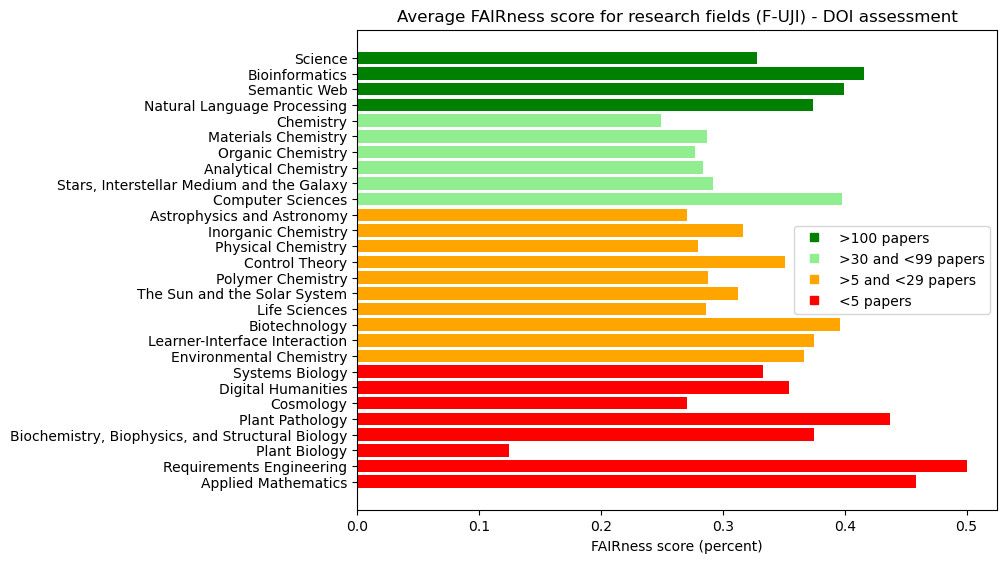

In [11]:
agg_funcs = {'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean'}
paper_doi_df_FAIR_fields = paper_doi_df_FAIR.groupby("research_field_label").agg(agg_funcs)
paper_doi_df_FAIR_fields["counts"] = paper_doi_df_FAIR["research_field_label"].value_counts()
paper_doi_df_FAIR_fields = paper_doi_df_FAIR_fields.sort_values("counts")
paper_doi_df_FAIR_fields = paper_doi_df_FAIR_fields.reset_index()

plot = plt.figure()
ax = plot.add_axes([0,0,1,1])
fields = paper_doi_df_FAIR_fields['research_field_label']
avg_scores = paper_doi_df_FAIR_fields['score_percent']
counts_color = [{p<5: 'red', 5<=p<30: 'orange', 30<=p<=100: 'lightgreen', p>100: 'green'}[True] for p in paper_doi_df_FAIR_fields["counts"]]
ax.barh(fields, avg_scores, color=counts_color)
leg_red = mlines.Line2D([], [], color="red", marker="s", ls='', label="<5 papers")
leg_orange = mlines.Line2D([], [], color="orange", marker="s", ls='', label=">5 and <29 papers")
leg_lightgreen = mlines.Line2D([], [], color="lightgreen", marker="s", ls='', label=">30 and <99 papers")
leg_green = mlines.Line2D([], [], color="green", marker="s", ls='', label=">100 papers")
plt.legend(handles=[leg_green, leg_lightgreen, leg_orange, leg_red])
plt.title("Average FAIRness score for research fields (F-UJI) - DOI assessment")
plt.xlabel("FAIRness score (percent)")
plt.show()

In [12]:
paper_doi_df_F_A_I_R = paper_doi_df_assessed
paper_doi_df_F_A_I_R["principle"] = paper_doi_df_F_A_I_R["metric"].map(lambda x: get_principle_from_metric(x))
paper_doi_df_F_A_I_R = paper_doi_df_F_A_I_R.groupby("principle").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
paper_doi_df_F_A_I_R["score_earned"] = paper_doi_df_F_A_I_R["score_earned"].map(lambda x: x/len(paper_doi_df_FAIR))
paper_doi_df_F_A_I_R["score_total"] = paper_doi_df_F_A_I_R["score_total"].map(lambda x: x/len(paper_doi_df_FAIR))
paper_doi_df_F_A_I_R["score_percent"] = paper_doi_df_F_A_I_R.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
paper_doi_df_F_A_I_R["principle"] = pd.Categorical(paper_doi_df_F_A_I_R["principle"], ["findable", "accessible", "interoperable", "reusable"])
paper_doi_df_F_A_I_R = paper_doi_df_F_A_I_R.sort_values("principle").reset_index(drop=True)
paper_doi_df_F_A_I_R

,principle,score_earned,score_total,score_percent
0,findable,3.367504,7.0,0.481072
1,accessible,0.931321,3.0,0.310440
2,interoperable,3.107982,4.0,0.776996
3,reusable,1.068274,10.0,0.106827


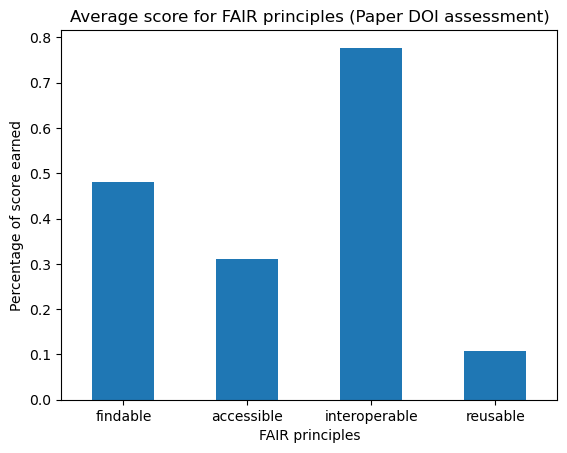

In [13]:
paper_doi_df_F_A_I_R["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["findable", "accessible", "interoperable", "reusable"], rotation=0)
plt.title("Average score for FAIR principles (Paper DOI assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("FAIR principles")
plt.show()

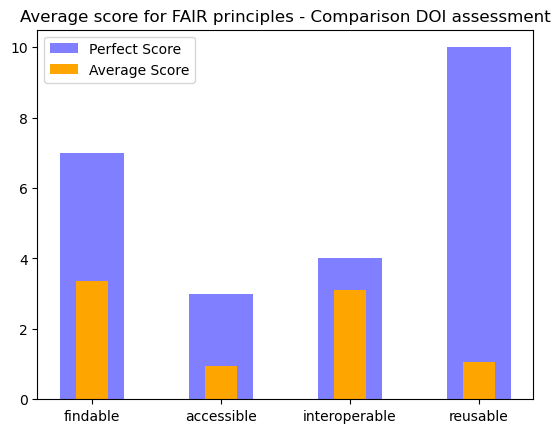

In [14]:
width = 0.5
perfect_scores = paper_doi_df_F_A_I_R["score_total"]
actual_scores = paper_doi_df_F_A_I_R['score_earned']
indices = np.arange(len(paper_doi_df_F_A_I_R['principle']))
plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, paper_doi_df_F_A_I_R['principle'] )
plt.title("Average score for FAIR principles - Comparison DOI assessment")
plt.legend()
plt.show()

In [15]:
paper_doi_df_submetrics = paper_doi_df_assessed
paper_doi_df_submetrics = paper_doi_df_submetrics.groupby("metric").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
paper_doi_df_submetrics["score_earned"] = paper_doi_df_submetrics["score_earned"].map(lambda x: x/len(paper_doi_df_FAIR))
paper_doi_df_submetrics["score_total"] = paper_doi_df_submetrics["score_total"].map(lambda x: x/len(paper_doi_df_FAIR))
paper_doi_df_submetrics["score_percent"] = paper_doi_df_submetrics.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
paper_doi_df_submetrics["metric"] = pd.Categorical(paper_doi_df_submetrics["metric"], ["FsF-F1-01D", "FsF-F1-02D", "FsF-F2-01M", "FsF-F3-01M", "FsF-F4-01M", "FsF-A1-01M", "FsF-A1-02M", "FsF-A1-03D", "FsF-I1-01M", "FsF-I2-01M", "FsF-I3-01M", "FsF-R1-01MD", "FsF-R1.1-01M", "FsF-R1.2-01M", "FsF-R1.3-01M", "FsF-R1.3-02D"])
paper_doi_df_submetrics = paper_doi_df_submetrics.sort_values("metric").reset_index(drop=True)
paper_doi_df_submetrics

,metric,score_earned,score_total,score_percent
0,FsF-F1-01D,1.000000,1.0,1.000000
1,FsF-F1-02D,0.896880,1.0,0.896880
2,FsF-F2-01M,0.734400,2.0,0.367200
3,FsF-F3-01M,0.000000,1.0,0.000000
4,FsF-F4-01M,0.736224,2.0,0.368112
5,FsF-A1-01M,0.034441,1.0,0.034441
6,FsF-A1-02M,0.896880,1.0,0.896880
7,FsF-A1-03D,0.000000,1.0,0.000000
8,FsF-I1-01M,1.533833,2.0,0.766917
9,FsF-I2-01M,0.994327,1.0,0.994327


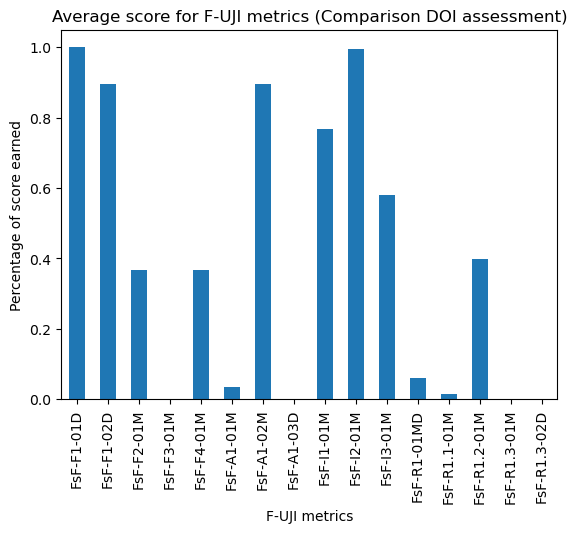

In [16]:
paper_doi_df_submetrics["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["FsF-F1-01D", "FsF-F1-02D", "FsF-F2-01M", "FsF-F3-01M", "FsF-F4-01M", "FsF-A1-01M", "FsF-A1-02M", "FsF-A1-03D", "FsF-I1-01M", "FsF-I2-01M", "FsF-I3-01M", "FsF-R1-01MD", "FsF-R1.1-01M", "FsF-R1.2-01M", "FsF-R1.3-01M", "FsF-R1.3-02D"])
plt.title("Average score for F-UJI metrics (Comparison DOI assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("F-UJI metrics")
plt.show()

## Paper evaluation via ORKG resource URL

### Paper assessment via ORKG resource URL

In [17]:
%%script false --no-raise-error
paper_url_df = pd.read_csv("raw_data/paper_query_result_2023-03-29.csv", encoding='ISO-8859-1').reset_index(drop=True)
paper_url_df = paper_url_df[["paper", "research_field_label"]].groupby("paper").agg({"research_field_label": "first"}).reset_index()
count = 0
paper_url_df["assessment_summary"] = paper_url_df["paper"].map(lambda x: get_assessment(x))
paper_url_df = paper_url_df[paper_url_df["assessment_summary"].isna() == False].reset_index(drop=True)
paper_url_df_assessed = expand_paper_df(paper_url_df)
paper_url_df_assessed.to_csv("assessed_data/paper_url_df_F-UJI_assessment.csv")
paper_url_df_assessed

Couldn't find program: 'false'


### Paper evaluation via ORKG resource URL + visualizations

In [18]:
paper_url_df_assessed = pd.read_csv("assessed_data/paper_url_df_F-UJI_assessment.csv", index_col=0)
paper_url_df_assessed

,paper,research_field_label,metric,score_earned,score_total
0,http://orkg.org/orkg/resource/R1004,Bioinformatics,FsF-F1-01D,1,1
1,http://orkg.org/orkg/resource/R1004,Bioinformatics,FsF-F1-02D,0,1
2,http://orkg.org/orkg/resource/R1004,Bioinformatics,FsF-F2-01M,0,2
3,http://orkg.org/orkg/resource/R1004,Bioinformatics,FsF-F3-01M,0,1
4,http://orkg.org/orkg/resource/R1004,Bioinformatics,FsF-F4-01M,0,2
...,...,...,...,...,...
207643,http://orkg.org/orkg/resource/R9639,Computer Sciences,FsF-R1.2-01M,0,2
207644,http://orkg.org/orkg/resource/R9639,Computer Sciences,FsF-R1.3-01M,0,1
207645,http://orkg.org/orkg/resource/R9639,Computer Sciences,FsF-R1.3-02D,0,1
207646,http://orkg.org/orkg/resource/R9639,Computer Sciences,FsF-A1-03D,0,1


In [19]:
paper_url_df_FAIR = paper_url_df_assessed.groupby("paper").agg({"research_field_label": "first", "score_earned": "sum", "score_total": "sum"}).reset_index()
paper_url_df_FAIR["score_percent"] = paper_url_df_FAIR.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
paper_url_df_FAIR

,paper,research_field_label,score_earned,score_total,score_percent
0,http://orkg.org/orkg/resource/R1004,Bioinformatics,1,24,0.041667
1,http://orkg.org/orkg/resource/R107618,Learner-Interface Interaction,1,24,0.041667
2,http://orkg.org/orkg/resource/R107663,Learner-Interface Interaction,1,24,0.041667
3,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,1,24,0.041667
4,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,1,24,0.041667
...,...,...,...,...,...
12973,http://orkg.org/orkg/resource/R8441,Systems Biology,1,24,0.041667
12974,http://orkg.org/orkg/resource/R9154,Life Sciences,1,24,0.041667
12975,http://orkg.org/orkg/resource/R9190,Biotechnology,1,24,0.041667
12976,http://orkg.org/orkg/resource/R9295,Biotechnology,1,24,0.041667


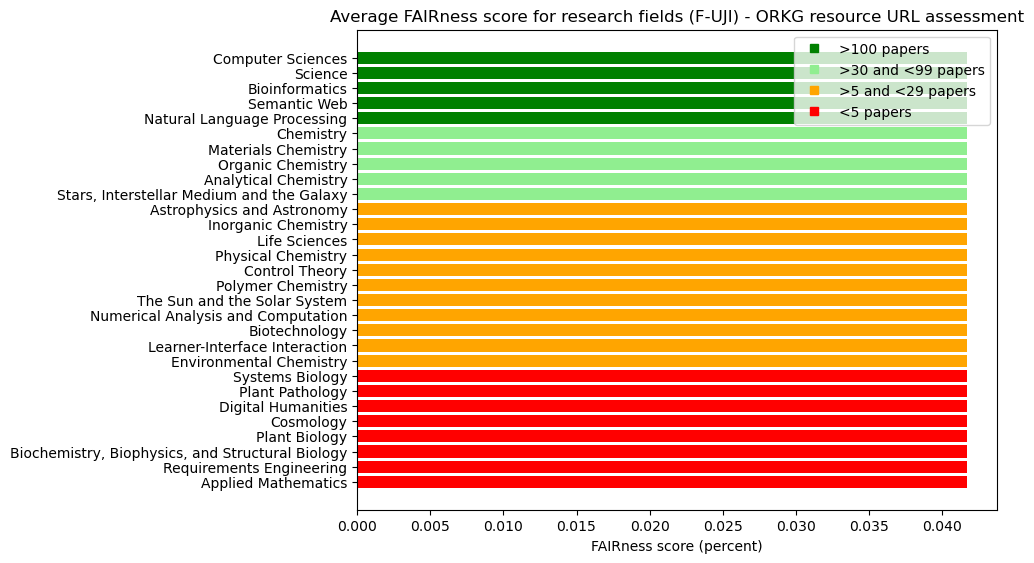

In [20]:
agg_funcs = {'score_earned': 'mean', 'score_percent': 'mean', 'score_total': "mean"}
paper_url_df_FAIR_fields = paper_url_df_FAIR.groupby("research_field_label").agg(agg_funcs)
paper_url_df_FAIR_fields["counts"] = paper_url_df_FAIR["research_field_label"].value_counts()
paper_url_df_FAIR_fields = paper_url_df_FAIR_fields.sort_values("counts")
paper_url_df_FAIR_fields = paper_url_df_FAIR_fields.reset_index()

plot = plt.figure()
ax = plot.add_axes([0,0,1,1])
fields = paper_url_df_FAIR_fields['research_field_label']
avg_scores = paper_url_df_FAIR_fields['score_percent']
counts_color = [{p<5: 'red', 5<=p<30: 'orange', 30<=p<=100: 'lightgreen', p>100: 'green'}[True] for p in paper_url_df_FAIR_fields["counts"]]
ax.barh(fields, avg_scores, color=counts_color)
leg_red = mlines.Line2D([], [], color="red", marker="s", ls='', label="<5 papers")
leg_orange = mlines.Line2D([], [], color="orange", marker="s", ls='', label=">5 and <29 papers")
leg_lightgreen = mlines.Line2D([], [], color="lightgreen", marker="s", ls='', label=">30 and <99 papers")
leg_green = mlines.Line2D([], [], color="green", marker="s", ls='', label=">100 papers")
plt.legend(handles=[leg_green, leg_lightgreen, leg_orange, leg_red])
plt.title("Average FAIRness score for research fields (F-UJI) - ORKG resource URL assessment")
plt.xlabel("FAIRness score (percent)")
plt.show()

In [21]:
paper_url_df_F_A_I_R = paper_url_df_assessed
paper_url_df_F_A_I_R["principle"] = paper_url_df_F_A_I_R["metric"].map(lambda x: get_principle_from_metric(x))
paper_url_df_F_A_I_R = paper_url_df_F_A_I_R.groupby("principle").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
paper_url_df_F_A_I_R["score_earned"] = paper_url_df_F_A_I_R["score_earned"].map(lambda x: x/len(paper_url_df_FAIR))
paper_url_df_F_A_I_R["score_total"] = paper_url_df_F_A_I_R["score_total"].map(lambda x: x/len(paper_url_df_FAIR))
paper_url_df_F_A_I_R["score_percent"] = paper_url_df_F_A_I_R.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
paper_url_df_F_A_I_R["principle"] = pd.Categorical(paper_url_df_F_A_I_R["principle"], ["findable", "accessible", "interoperable", "reusable"])
paper_url_df_F_A_I_R = paper_url_df_F_A_I_R.sort_values("principle").reset_index(drop=True)
paper_url_df_F_A_I_R

,principle,score_earned,score_total,score_percent
0,findable,1.0,7.0,0.142857
1,accessible,0.0,3.0,0.000000
2,interoperable,0.0,4.0,0.000000
3,reusable,0.0,10.0,0.000000


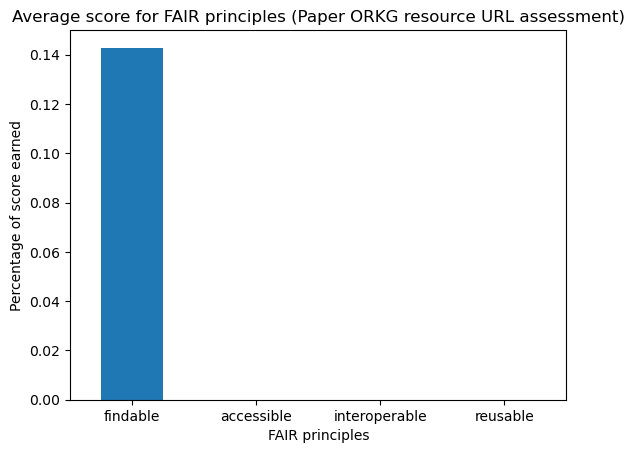

In [22]:
paper_url_df_F_A_I_R["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["findable", "accessible", "interoperable", "reusable"], rotation=0)
plt.title("Average score for FAIR principles (Paper ORKG resource URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("FAIR principles")
plt.show()

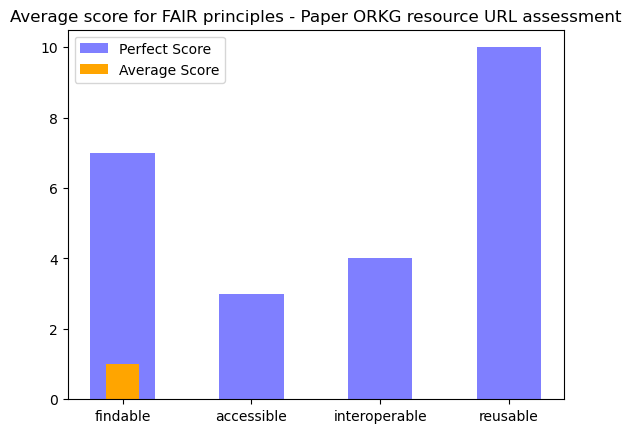

In [23]:
width = 0.5
perfect_scores = paper_url_df_F_A_I_R["score_total"]
actual_scores = paper_url_df_F_A_I_R['score_earned']
indices = np.arange(len(paper_url_df_F_A_I_R['principle']))
plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, paper_url_df_F_A_I_R['principle'] )
plt.title("Average score for FAIR principles - Paper ORKG resource URL assessment")
plt.legend()
plt.show()

In [24]:
paper_url_df_submetrics = paper_url_df_assessed
paper_url_df_submetrics = paper_url_df_submetrics.groupby("metric").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
paper_url_df_submetrics["score_earned"] = paper_url_df_submetrics["score_earned"].map(lambda x: x/len(paper_url_df_FAIR))
paper_url_df_submetrics["score_total"] = paper_url_df_submetrics["score_total"].map(lambda x: x/len(paper_url_df_FAIR))
paper_url_df_submetrics["score_percent"] = paper_url_df_submetrics.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
paper_url_df_submetrics["metric"] = pd.Categorical(paper_url_df_submetrics["metric"], ["FsF-F1-01D", "FsF-F1-02D", "FsF-F2-01M", "FsF-F3-01M", "FsF-F4-01M", "FsF-A1-01M", "FsF-A1-02M", "FsF-A1-03D", "FsF-I1-01M", "FsF-I2-01M", "FsF-I3-01M", "FsF-R1-01MD", "FsF-R1.1-01M", "FsF-R1.2-01M", "FsF-R1.3-01M", "FsF-R1.3-02D"])
paper_url_df_submetrics = paper_url_df_submetrics.sort_values("metric").reset_index(drop=True)
paper_url_df_submetrics

,metric,score_earned,score_total,score_percent
0,FsF-F1-01D,1.0,1.0,1.0
1,FsF-F1-02D,0.0,1.0,0.0
2,FsF-F2-01M,0.0,2.0,0.0
3,FsF-F3-01M,0.0,1.0,0.0
4,FsF-F4-01M,0.0,2.0,0.0
5,FsF-A1-01M,0.0,1.0,0.0
6,FsF-A1-02M,0.0,1.0,0.0
7,FsF-A1-03D,0.0,1.0,0.0
8,FsF-I1-01M,0.0,2.0,0.0
9,FsF-I2-01M,0.0,1.0,0.0


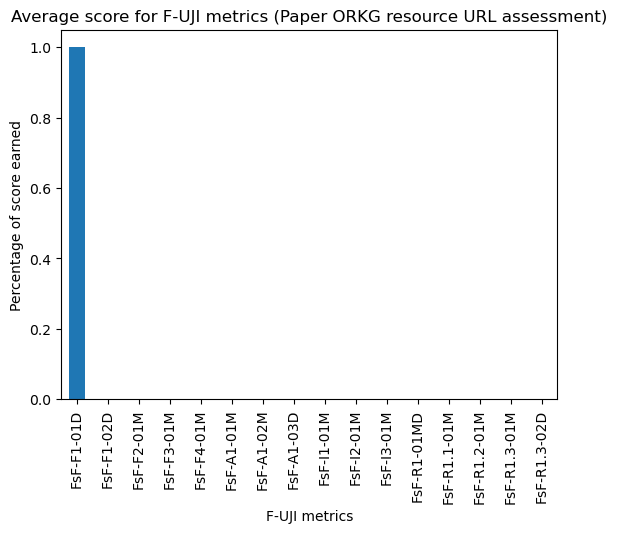

In [25]:
paper_url_df_submetrics["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["FsF-F1-01D", "FsF-F1-02D", "FsF-F2-01M", "FsF-F3-01M", "FsF-F4-01M", "FsF-A1-01M", "FsF-A1-02M", "FsF-A1-03D", "FsF-I1-01M", "FsF-I2-01M", "FsF-I3-01M", "FsF-R1-01MD", "FsF-R1.1-01M", "FsF-R1.2-01M", "FsF-R1.3-01M", "FsF-R1.3-02D"])
plt.title("Average score for F-UJI metrics (Paper ORKG resource URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("F-UJI metrics")
plt.show()

## Paper evaluation via standard URL

### Paper assessment via standard URL

In [26]:
%%script false --no-raise-error
paper_stdurl_df = pd.read_csv("raw_data/paper_query_result_2023-03-29.csv", encoding='ISO-8859-1').reset_index(drop=True)
paper_stdurl_df = paper_stdurl_df[["paper", "research_field_label", "url"]].groupby("paper").agg({"research_field_label": "first", "url": "first"}).reset_index()
paper_stdurl_df = paper_stdurl_df[paper_stdurl_df["url"].isna() == False].reset_index(drop=True)
count = 0
paper_stdurl_df["assessment_summary"] = paper_stdurl_df["url"].map(lambda x: get_assessment(x))
paper_stdurl_df = paper_stdurl_df[paper_stdurl_df["assessment_summary"].isna() == False].reset_index(drop=True)
paper_stdurl_df_assessed = expand_paper_df(paper_stdurl_df)
paper_stdurl_df_assessed.to_csv("assessed_data/paper_stdurl_df_F-UJI_assessment.csv")
paper_stdurl_df_assessed

Couldn't find program: 'false'


### Paper evaluation via standard URL + visualizations

In [27]:
paper_stdurl_df_assessed = pd.read_csv("assessed_data/paper_stdurl_df_F-UJI_assessment.csv")
paper_stdurl_df_assessed

,Unnamed: 0,paper,research_field_label,metric,score_earned,score_total
0,0,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,FsF-F1-01D,1,1
1,1,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,FsF-F1-02D,0,1
2,2,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,FsF-F2-01M,0,2
3,3,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,FsF-F3-01M,0,1
4,4,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,FsF-F4-01M,0,2
...,...,...,...,...,...,...
129099,129099,http://orkg.org/orkg/resource/R78345,Physical Chemistry,FsF-R1.2-01M,0,2
129100,129100,http://orkg.org/orkg/resource/R78345,Physical Chemistry,FsF-R1.3-01M,0,1
129101,129101,http://orkg.org/orkg/resource/R78345,Physical Chemistry,FsF-R1.3-02D,0,1
129102,129102,http://orkg.org/orkg/resource/R78345,Physical Chemistry,FsF-A1-03D,0,1


In [28]:
paper_stdurl_df_FAIR = paper_stdurl_df_assessed.groupby("paper").agg({"research_field_label": "first", "score_earned": "sum", "score_total": "sum"}).reset_index()
paper_stdurl_df_FAIR["score_percent"] = paper_stdurl_df_FAIR.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
paper_stdurl_df_FAIR

,paper,research_field_label,score_earned,score_total,score_percent
0,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,1,24,0.041667
1,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,5,24,0.208333
2,http://orkg.org/orkg/resource/R108529,Computer Sciences,9,24,0.375000
3,http://orkg.org/orkg/resource/R108693,Biotechnology,11,24,0.458333
4,http://orkg.org/orkg/resource/R108704,Plant Pathology,9,24,0.375000
...,...,...,...,...,...
8064,http://orkg.org/orkg/resource/R78136,Life Sciences,1,24,0.041667
8065,http://orkg.org/orkg/resource/R78139,Life Sciences,1,24,0.041667
8066,http://orkg.org/orkg/resource/R78145,Life Sciences,1,24,0.041667
8067,http://orkg.org/orkg/resource/R78301,Environmental Chemistry,9,24,0.375000


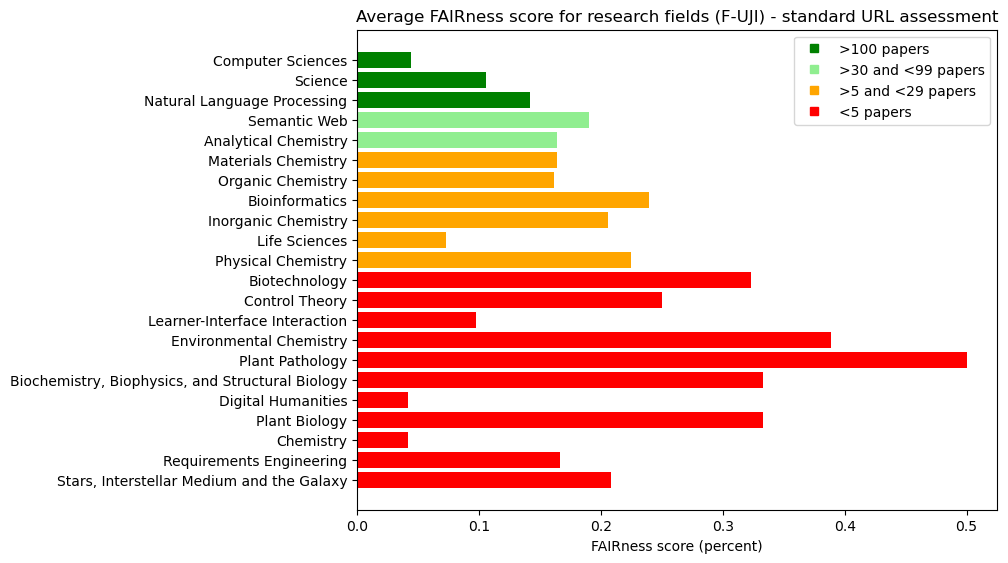

In [29]:
agg_funcs = {'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean'}
paper_stdurl_df_FAIR_fields = paper_stdurl_df_FAIR.groupby("research_field_label").agg(agg_funcs)
paper_stdurl_df_FAIR_fields["counts"] = paper_stdurl_df_FAIR["research_field_label"].value_counts()
paper_stdurl_df_FAIR_fields = paper_stdurl_df_FAIR_fields.sort_values("counts")
paper_stdurl_df_FAIR_fields = paper_stdurl_df_FAIR_fields.reset_index()

plot = plt.figure()
ax = plot.add_axes([0,0,1,1])
fields = paper_stdurl_df_FAIR_fields['research_field_label']
avg_scores = paper_stdurl_df_FAIR_fields['score_percent']
counts_color = [{p<5: 'red', 5<=p<30: 'orange', 30<=p<=100: 'lightgreen', p>100: 'green'}[True] for p in paper_stdurl_df_FAIR_fields["counts"]]
ax.barh(fields, avg_scores, color=counts_color)
leg_red = mlines.Line2D([], [], color="red", marker="s", ls='', label="<5 papers")
leg_orange = mlines.Line2D([], [], color="orange", marker="s", ls='', label=">5 and <29 papers")
leg_lightgreen = mlines.Line2D([], [], color="lightgreen", marker="s", ls='', label=">30 and <99 papers")
leg_green = mlines.Line2D([], [], color="green", marker="s", ls='', label=">100 papers")
plt.legend(handles=[leg_green, leg_lightgreen, leg_orange, leg_red])
plt.title("Average FAIRness score for research fields (F-UJI) - standard URL assessment")
plt.xlabel("FAIRness score (percent)")
plt.show()

In [30]:
paper_stdurl_df_F_A_I_R = paper_stdurl_df_assessed
paper_stdurl_df_F_A_I_R["principle"] = paper_stdurl_df_F_A_I_R["metric"].map(lambda x: get_principle_from_metric(x))
paper_stdurl_df_F_A_I_R = paper_stdurl_df_F_A_I_R.groupby("principle").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
paper_stdurl_df_F_A_I_R["score_earned"] = paper_stdurl_df_F_A_I_R["score_earned"].map(lambda x: x/len(paper_stdurl_df_FAIR))
paper_stdurl_df_F_A_I_R["score_total"] = paper_stdurl_df_F_A_I_R["score_total"].map(lambda x: x/len(paper_stdurl_df_FAIR))
paper_stdurl_df_F_A_I_R["score_percent"] = paper_stdurl_df_F_A_I_R.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
paper_stdurl_df_F_A_I_R["principle"] = pd.Categorical(paper_stdurl_df_F_A_I_R["principle"], ["findable", "accessible", "interoperable", "reusable"])
paper_stdurl_df_F_A_I_R = paper_stdurl_df_F_A_I_R.sort_values("principle").reset_index(drop=True)
paper_stdurl_df_F_A_I_R

,principle,score_earned,score_total,score_percent
0,findable,1.103235,7.0,0.157605
1,accessible,0.087247,3.0,0.029082
2,interoperable,0.067542,4.0,0.016886
3,reusable,0.085265,10.0,0.008526


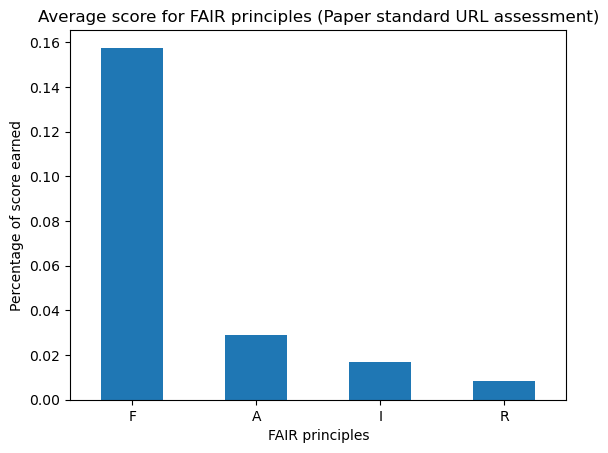

In [31]:
paper_stdurl_df_F_A_I_R["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F", "A", "I", "R"], rotation=0)
plt.title("Average score for FAIR principles (Paper standard URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("FAIR principles")
plt.show()

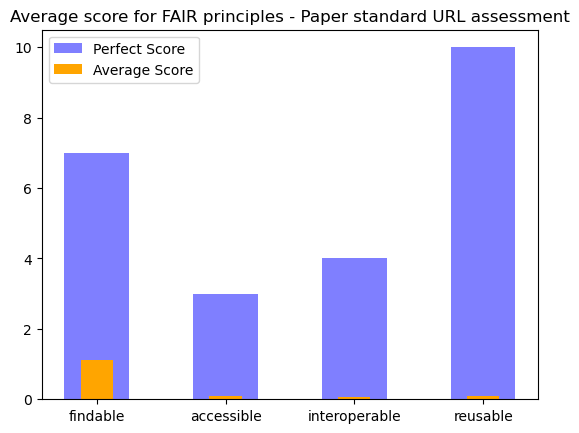

In [32]:
width = 0.5
perfect_scores = paper_stdurl_df_F_A_I_R["score_total"]
actual_scores = paper_stdurl_df_F_A_I_R['score_earned']
indices = np.arange(len(paper_stdurl_df_F_A_I_R['principle']))
plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, paper_stdurl_df_F_A_I_R['principle'] )
plt.title("Average score for FAIR principles - Paper standard URL assessment")
plt.legend()
plt.show()

In [33]:
paper_stdurl_df_submetrics = paper_stdurl_df_assessed
paper_stdurl_df_submetrics = paper_stdurl_df_submetrics.groupby("metric").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
paper_stdurl_df_submetrics["score_earned"] = paper_stdurl_df_submetrics["score_earned"].map(lambda x: x/len(paper_stdurl_df_FAIR))
paper_stdurl_df_submetrics["score_total"] = paper_stdurl_df_submetrics["score_total"].map(lambda x: x/len(paper_stdurl_df_FAIR))
paper_stdurl_df_submetrics["score_percent"] = paper_stdurl_df_submetrics.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
paper_stdurl_df_submetrics["metric"] = pd.Categorical(paper_stdurl_df_submetrics["metric"], ["FsF-F1-01D", "FsF-F1-02D", "FsF-F2-01M", "FsF-F3-01M", "FsF-F4-01M", "FsF-A1-01M", "FsF-A1-02M", "FsF-A1-03D", "FsF-I1-01M", "FsF-I2-01M", "FsF-I3-01M", "FsF-R1-01MD", "FsF-R1.1-01M", "FsF-R1.2-01M", "FsF-R1.3-01M", "FsF-R1.3-02D"])
paper_stdurl_df_submetrics = paper_stdurl_df_submetrics.sort_values("metric").reset_index(drop=True)
paper_stdurl_df_submetrics

,metric,score_earned,score_total,score_percent
0,FsF-F1-01D,0.998761,1.0,0.998761
1,FsF-F1-02D,0.022308,1.0,0.022308
2,FsF-F2-01M,0.025654,2.0,0.012827
3,FsF-F3-01M,0.000000,1.0,0.000000
4,FsF-F4-01M,0.056513,2.0,0.028256
5,FsF-A1-01M,0.004214,1.0,0.004214
6,FsF-A1-02M,0.083034,1.0,0.083034
7,FsF-A1-03D,0.000000,1.0,0.000000
8,FsF-I1-01M,0.032842,2.0,0.016421
9,FsF-I2-01M,0.021440,1.0,0.021440


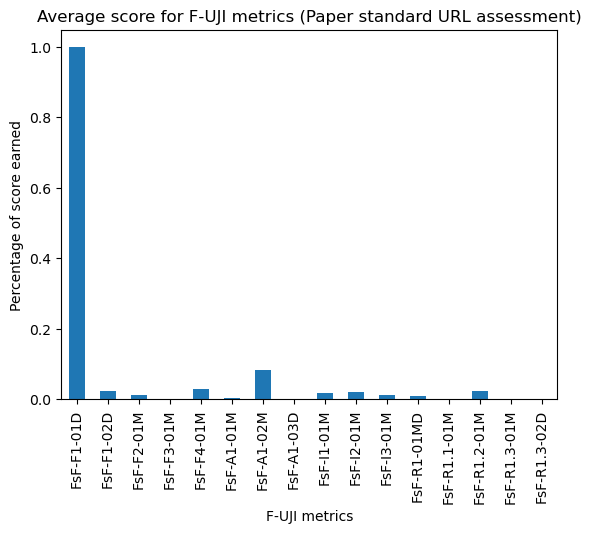

In [34]:
paper_stdurl_df_submetrics["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["FsF-F1-01D", "FsF-F1-02D", "FsF-F2-01M", "FsF-F3-01M", "FsF-F4-01M", "FsF-A1-01M", "FsF-A1-02M", "FsF-A1-03D", "FsF-I1-01M", "FsF-I2-01M", "FsF-I3-01M", "FsF-R1-01MD", "FsF-R1.1-01M", "FsF-R1.2-01M", "FsF-R1.3-01M", "FsF-R1.3-02D"])
plt.title("Average score for F-UJI metrics (Paper standard URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("F-UJI metrics")
plt.show()

# Comparisons

In [35]:
def expand_comp_assessment_result(df):
    df_exp = pd.DataFrame()
    df_exp["comparison"] = list(chain.from_iterable([[x]*16 for x in df["comparisons"]]))
    df_exp["doi"] = list(chain.from_iterable([[x]*16 for x in df["doi"]]))
    df_exp["metric"] = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in df["assessment_summary"]]))
    df_exp["score_earned"] = list(chain.from_iterable([get_earned_scores_from_result(assessment_result=x) for x in df["assessment_summary"]]))
    df_exp["score_total"] = list(chain.from_iterable([get_total_scores_from_result(assessment_result=x) for x in df["assessment_summary"]]))
    return df_exp

## Comparison evaluation via DOI

### Comparison assessment via DOI

In [36]:
%%script false --no-raise-error
comp_doi_df = pd.read_csv("raw_data/comparison_query_result_2023-03-29.csv")
comp_doi_df = comp_doi_df[comp_doi_df["doi"].isna() == False].reset_index(drop=True)
count = 0
comp_doi_df["assessment_summary"] = comp_doi_df["doi"].map(lambda x: get_assessment("https://doi.org/" + x))
comp_doi_df

Couldn't find program: 'false'


In [37]:
%%script false --no-raise-error
comp_doi_df_assessed = expand_comp_assessment_result(comp_doi_df)
comp_doi_df_assessed.to_csv("assessed_data/comparison_doi_df_F-UJI_assessment.csv")
comp_doi_df_assessed

Couldn't find program: 'false'


### Comparisons evaluation via DOI + visualizations

In [38]:
comp_doi_df_assessed = pd.read_csv("assessed_data/comparison_doi_df_F-UJI_assessment.csv", index_col=0)
comp_doi_df_assessed

,comparison,doi,metric,score_earned,score_total
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F1-01D,1,1
1,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F1-02D,1,1
2,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F2-01M,2,2
3,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F3-01M,0,1
4,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F4-01M,2,2
...,...,...,...,...,...
4699,http://orkg.org/orkg/resource/R576876,10.48366/r576876,FsF-R1.2-01M,1,2
4700,http://orkg.org/orkg/resource/R576876,10.48366/r576876,FsF-R1.3-01M,0,1
4701,http://orkg.org/orkg/resource/R576876,10.48366/r576876,FsF-R1.3-02D,0,1
4702,http://orkg.org/orkg/resource/R576876,10.48366/r576876,FsF-A1-03D,0,1


In [39]:
comp_doi_df_FAIR = comp_doi_df_assessed.groupby("comparison").agg({"doi": "first", "score_earned": "sum", "score_total": "sum"}).reset_index()
comp_doi_df_FAIR["score_percent"] = comp_doi_df_FAIR.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
comp_doi_df_FAIR

,comparison,doi,score_earned,score_total,score_percent
0,http://orkg.org/orkg/resource/R107854,10.48366/r107854,12,24,0.5
1,http://orkg.org/orkg/resource/R108358,10.48366/r108358,12,24,0.5
2,http://orkg.org/orkg/resource/R108601,10.48366/r108601,12,24,0.5
3,http://orkg.org/orkg/resource/R108719,10.48366/r108719,12,24,0.5
4,http://orkg.org/orkg/resource/R109041,10.48366/r109041,12,24,0.5
...,...,...,...,...,...
289,http://orkg.org/orkg/resource/R76906,10.48366/r76906,12,24,0.5
290,http://orkg.org/orkg/resource/R78163,10.48366/r78163,12,24,0.5
291,http://orkg.org/orkg/resource/R78454,10.48366/r78454,12,24,0.5
292,http://orkg.org/orkg/resource/R8342,10.48366/r8342,12,24,0.5


In [40]:
comp_doi_df_F_A_I_R = comp_doi_df_assessed
comp_doi_df_F_A_I_R["principle"] = comp_doi_df_F_A_I_R["metric"].map(lambda x: get_principle_from_metric(x))
comp_doi_df_F_A_I_R = comp_doi_df_F_A_I_R.groupby("principle").agg({"comparison": "first", "doi": "first", "score_earned": "sum", "score_total": "sum"}).reset_index()
comp_doi_df_F_A_I_R["score_earned"] = comp_doi_df_F_A_I_R["score_earned"].map(lambda x: x/len(comp_doi_df_FAIR))
comp_doi_df_F_A_I_R["score_total"] = comp_doi_df_F_A_I_R["score_total"].map(lambda x: x/len(comp_doi_df_FAIR))
comp_doi_df_F_A_I_R["score_percent"] = comp_doi_df_F_A_I_R.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
comp_doi_df_F_A_I_R["principle"] = pd.Categorical(comp_doi_df_F_A_I_R["principle"], ["findable", "accessible", "interoperable", "reusable"])
comp_doi_df_F_A_I_R = comp_doi_df_F_A_I_R.sort_values("principle").reset_index(drop=True)
comp_doi_df_F_A_I_R

,principle,comparison,doi,score_earned,score_total,score_percent
0,findable,http://orkg.org/orkg/resource/R140347,10.48366/r140347,5.962585,7.0,0.851798
1,accessible,http://orkg.org/orkg/resource/R140347,10.48366/r140347,1.000000,3.0,0.333333
2,interoperable,http://orkg.org/orkg/resource/R140347,10.48366/r140347,1.000000,4.0,0.250000
3,reusable,http://orkg.org/orkg/resource/R140347,10.48366/r140347,4.000000,10.0,0.400000


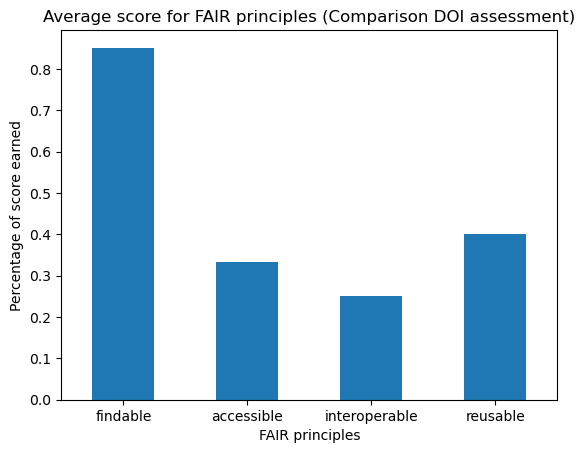

In [41]:
comp_doi_df_F_A_I_R["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["findable", "accessible", "interoperable", "reusable"], rotation=0)
plt.title("Average score for FAIR principles (Comparison DOI assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("FAIR principles")
plt.show()

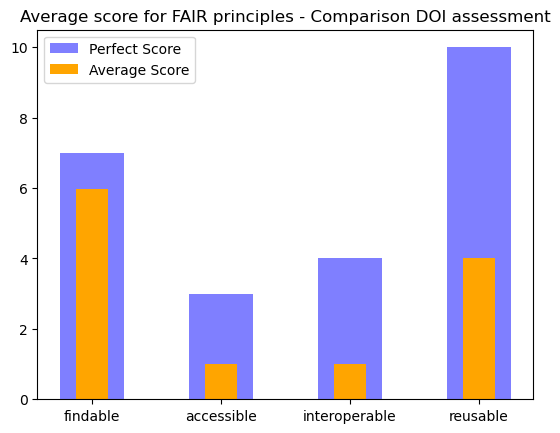

In [42]:
width = 0.5
perfect_scores = comp_doi_df_F_A_I_R["score_total"]
actual_scores = comp_doi_df_F_A_I_R['score_earned']
indices = np.arange(len(comp_doi_df_F_A_I_R['principle']))
plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, comp_doi_df_F_A_I_R['principle'] )
plt.title("Average score for FAIR principles - Comparison DOI assessment")
plt.legend()
plt.show()

In [43]:
comp_doi_df_submetrics = comp_doi_df_assessed
comp_doi_df_submetrics = comp_doi_df_submetrics.groupby("metric").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
comp_doi_df_submetrics["score_earned"] = comp_doi_df_submetrics["score_earned"].map(lambda x: x/len(comp_doi_df_FAIR))
comp_doi_df_submetrics["score_total"] = comp_doi_df_submetrics["score_total"].map(lambda x: x/len(comp_doi_df_FAIR))
comp_doi_df_submetrics["score_percent"] = comp_doi_df_submetrics.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
comp_doi_df_submetrics["metric"] = pd.Categorical(comp_doi_df_submetrics["metric"], ["FsF-F1-01D", "FsF-F1-02D", "FsF-F2-01M", "FsF-F3-01M", "FsF-F4-01M", "FsF-A1-01M", "FsF-A1-02M", "FsF-A1-03D", "FsF-I1-01M", "FsF-I2-01M", "FsF-I3-01M", "FsF-R1-01MD", "FsF-R1.1-01M", "FsF-R1.2-01M", "FsF-R1.3-01M", "FsF-R1.3-02D"])
comp_doi_df_submetrics = comp_doi_df_submetrics.sort_values("metric").reset_index(drop=True)
comp_doi_df_submetrics

,metric,score_earned,score_total,score_percent
0,FsF-F1-01D,1.000000,1.0,1.000000
1,FsF-F1-02D,1.000000,1.0,1.000000
2,FsF-F2-01M,1.962585,2.0,0.981293
3,FsF-F3-01M,0.000000,1.0,0.000000
4,FsF-F4-01M,2.000000,2.0,1.000000
5,FsF-A1-01M,0.000000,1.0,0.000000
6,FsF-A1-02M,1.000000,1.0,1.000000
7,FsF-A1-03D,0.000000,1.0,0.000000
8,FsF-I1-01M,1.000000,2.0,0.500000
9,FsF-I2-01M,0.000000,1.0,0.000000


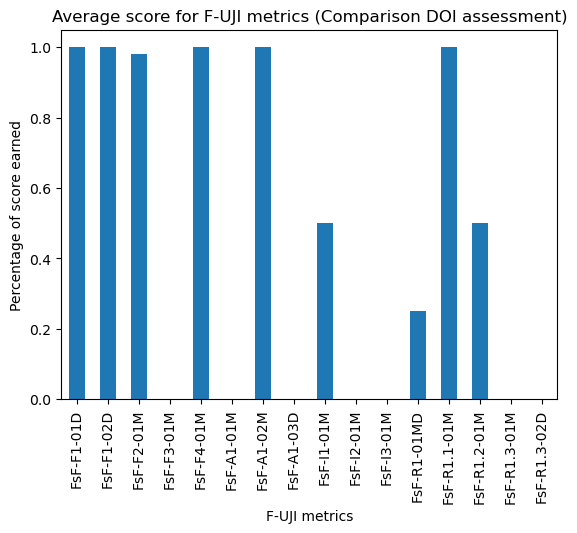

In [44]:
comp_doi_df_submetrics["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["FsF-F1-01D", "FsF-F1-02D", "FsF-F2-01M", "FsF-F3-01M", "FsF-F4-01M", "FsF-A1-01M", "FsF-A1-02M", "FsF-A1-03D", "FsF-I1-01M", "FsF-I2-01M", "FsF-I3-01M", "FsF-R1-01MD", "FsF-R1.1-01M", "FsF-R1.2-01M", "FsF-R1.3-01M", "FsF-R1.3-02D"])
plt.title("Average score for F-UJI metrics (Comparison DOI assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("F-UJI metrics")
plt.show()

## Comparison evaluation via ORKG resource URL

### Comparison assessment via ORKG resource URL

In [45]:
%%script false --no-raise-error
comp_url_df = pd.read_csv("raw_data/comparison_query_result_2023-03-29.csv")
count = 0
comp_url_df["assessment_summary"] = comp_url_df["comparisons"].map(lambda x: get_assessment(x))
comp_url_df_assessed = expand_comp_assessment_result(comp_url_df)
comp_url_df_assessed.to_csv("assessed_data/comparison_url_df_F-UJI_assessment.csv")
comp_url_df_assessed

Couldn't find program: 'false'


### Comparisons evaluation via ORKG resource URL + visualizations

In [46]:
comp_url_df_assessed = pd.read_csv("assessed_data/comparison_url_df_F-UJI_assessment.csv", index_col=0)
comp_url_df_assessed

,comparison,doi,metric,score_earned,score_total
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F1-01D,1,1
1,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F1-02D,0,1
2,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F2-01M,0,2
3,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F3-01M,0,1
4,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F4-01M,0,2
...,...,...,...,...,...
18379,http://orkg.org/orkg/resource/R288673,NaN,FsF-R1.2-01M,0,2
18380,http://orkg.org/orkg/resource/R288673,NaN,FsF-R1.3-01M,0,1
18381,http://orkg.org/orkg/resource/R288673,NaN,FsF-R1.3-02D,0,1
18382,http://orkg.org/orkg/resource/R288673,NaN,FsF-A1-03D,0,1


In [47]:
comp_url_df_FAIR = comp_url_df_assessed.groupby("comparison").agg({"doi": "first", "score_earned": "sum", "score_total": "sum"}).reset_index()
comp_url_df_FAIR["score_percent"] = comp_url_df_FAIR.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
comp_url_df_FAIR

,comparison,doi,score_earned,score_total,score_percent
0,http://orkg.org/orkg/resource/R107661,None,1,24,0.041667
1,http://orkg.org/orkg/resource/R107676,None,1,24,0.041667
2,http://orkg.org/orkg/resource/R107854,10.48366/r107854,1,24,0.041667
3,http://orkg.org/orkg/resource/R108053,None,1,24,0.041667
4,http://orkg.org/orkg/resource/R108232,None,1,24,0.041667
...,...,...,...,...,...
1144,http://orkg.org/orkg/resource/R8341,None,1,24,0.041667
1145,http://orkg.org/orkg/resource/R8342,10.48366/r8342,1,24,0.041667
1146,http://orkg.org/orkg/resource/R8364,10.48366/r8364,1,24,0.041667
1147,http://orkg.org/orkg/resource/R8453,None,1,24,0.041667


In [48]:
comp_url_df_F_A_I_R = comp_url_df_assessed
comp_url_df_F_A_I_R["principle"] = comp_url_df_F_A_I_R["metric"].map(lambda x: get_principle_from_metric(x))
comp_url_df_F_A_I_R = comp_url_df_F_A_I_R.groupby("principle").agg({"comparison": "first", "doi": "first", "score_earned": "sum", "score_total": "sum"}).reset_index()
comp_url_df_F_A_I_R["score_earned"] = comp_url_df_F_A_I_R["score_earned"].map(lambda x: x/len(comp_url_df_FAIR))
comp_url_df_F_A_I_R["score_total"] = comp_url_df_F_A_I_R["score_total"].map(lambda x: x/len(comp_url_df_FAIR))
comp_url_df_F_A_I_R["score_percent"] = comp_url_df_F_A_I_R.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
comp_url_df_F_A_I_R["principle"] = pd.Categorical(comp_url_df_F_A_I_R["principle"], ["findable", "accessible", "interoperable", "reusable"])
comp_url_df_F_A_I_R = comp_url_df_F_A_I_R.sort_values("principle").reset_index(drop=True)
comp_url_df_F_A_I_R

,principle,comparison,doi,score_earned,score_total,score_percent
0,findable,http://orkg.org/orkg/resource/R140347,10.48366/r140347,1.0,7.0,0.142857
1,accessible,http://orkg.org/orkg/resource/R140347,10.48366/r140347,0.0,3.0,0.000000
2,interoperable,http://orkg.org/orkg/resource/R140347,10.48366/r140347,0.0,4.0,0.000000
3,reusable,http://orkg.org/orkg/resource/R140347,10.48366/r140347,0.0,10.0,0.000000


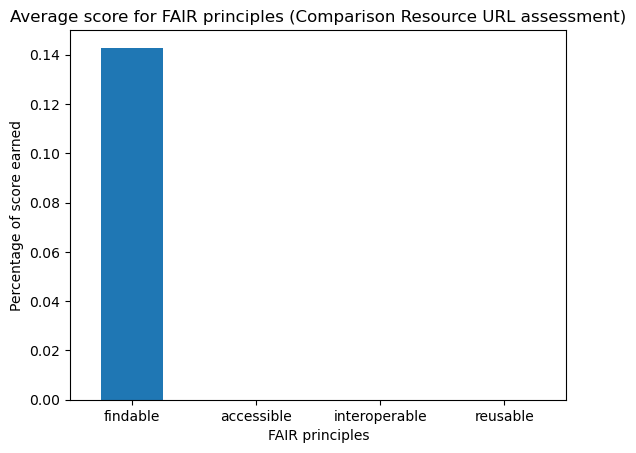

In [49]:
comp_url_df_F_A_I_R["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["findable", "accessible", "interoperable", "reusable"], rotation=0)
plt.title("Average score for FAIR principles (Comparison Resource URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("FAIR principles")
plt.show()

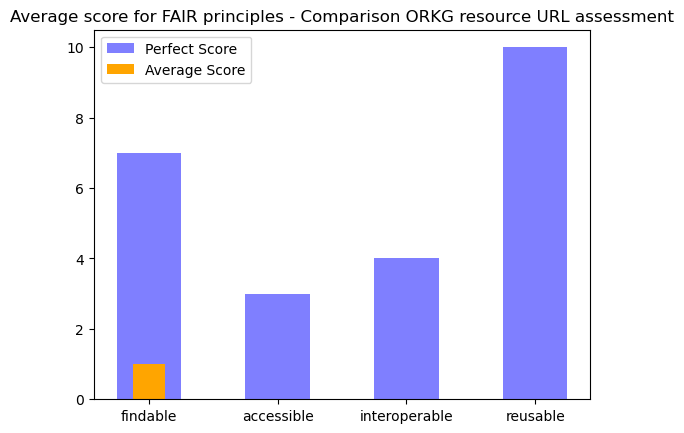

In [50]:
width = 0.5
perfect_scores = comp_url_df_F_A_I_R["score_total"]
actual_scores = comp_url_df_F_A_I_R['score_earned']
indices = np.arange(len(comp_url_df_F_A_I_R['principle']))
plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, comp_url_df_F_A_I_R['principle'])
plt.title("Average score for FAIR principles - Comparison ORKG resource URL assessment")
plt.legend()
plt.show()

In [51]:
comp_url_df_submetrics = comp_url_df_assessed
comp_url_df_submetrics = comp_url_df_submetrics.groupby("metric").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
comp_url_df_submetrics["score_earned"] = comp_url_df_submetrics["score_earned"].map(lambda x: x/len(comp_url_df_FAIR))
comp_url_df_submetrics["score_total"] = comp_url_df_submetrics["score_total"].map(lambda x: x/len(comp_url_df_FAIR))
comp_url_df_submetrics["score_percent"] = comp_url_df_submetrics.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
comp_url_df_submetrics["metric"] = pd.Categorical(comp_url_df_submetrics["metric"], ["FsF-F1-01D", "FsF-F1-02D", "FsF-F2-01M", "FsF-F3-01M", "FsF-F4-01M", "FsF-A1-01M", "FsF-A1-02M", "FsF-A1-03D", "FsF-I1-01M", "FsF-I2-01M", "FsF-I3-01M", "FsF-R1-01MD", "FsF-R1.1-01M", "FsF-R1.2-01M", "FsF-R1.3-01M", "FsF-R1.3-02D"])
comp_url_df_submetrics = comp_url_df_submetrics.sort_values("metric").reset_index(drop=True)
comp_url_df_submetrics

,metric,score_earned,score_total,score_percent
0,FsF-F1-01D,1.0,1.0,1.0
1,FsF-F1-02D,0.0,1.0,0.0
2,FsF-F2-01M,0.0,2.0,0.0
3,FsF-F3-01M,0.0,1.0,0.0
4,FsF-F4-01M,0.0,2.0,0.0
5,FsF-A1-01M,0.0,1.0,0.0
6,FsF-A1-02M,0.0,1.0,0.0
7,FsF-A1-03D,0.0,1.0,0.0
8,FsF-I1-01M,0.0,2.0,0.0
9,FsF-I2-01M,0.0,1.0,0.0


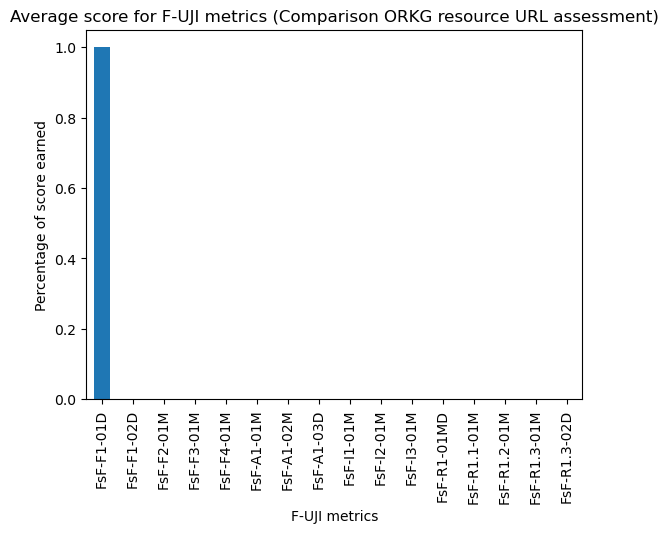

In [52]:
comp_url_df_submetrics["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["FsF-F1-01D", "FsF-F1-02D", "FsF-F2-01M", "FsF-F3-01M", "FsF-F4-01M", "FsF-A1-01M", "FsF-A1-02M", "FsF-A1-03D", "FsF-I1-01M", "FsF-I2-01M", "FsF-I3-01M", "FsF-R1-01MD", "FsF-R1.1-01M", "FsF-R1.2-01M", "FsF-R1.3-01M", "FsF-R1.3-02D"])
plt.title("Average score for F-UJI metrics (Comparison ORKG resource URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("F-UJI metrics")
plt.show()

## Comparison of comparisons

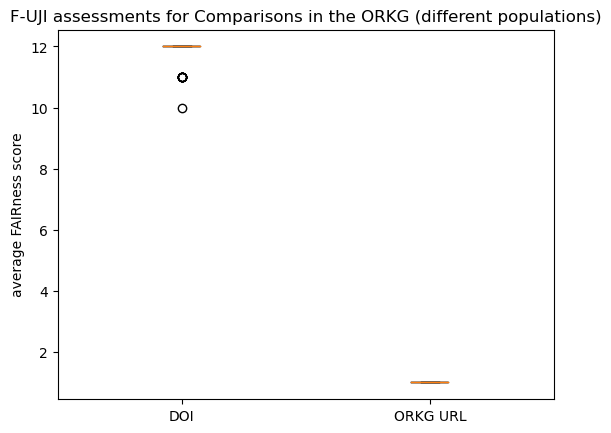

In [53]:
doi_df = comp_doi_df_FAIR
orkg_resource_url_df = comp_url_df_FAIR

assessement_data = [doi_df["score_earned"], orkg_resource_url_df["score_earned"]]
plt.boxplot(assessement_data)
plt.title("F-UJI assessments for Comparisons in the ORKG (different populations)")
locs, labels = plt.xticks()
plt.xticks(locs, ["DOI", "ORKG URL"])
plt.ylabel("average FAIRness score")
plt.show()

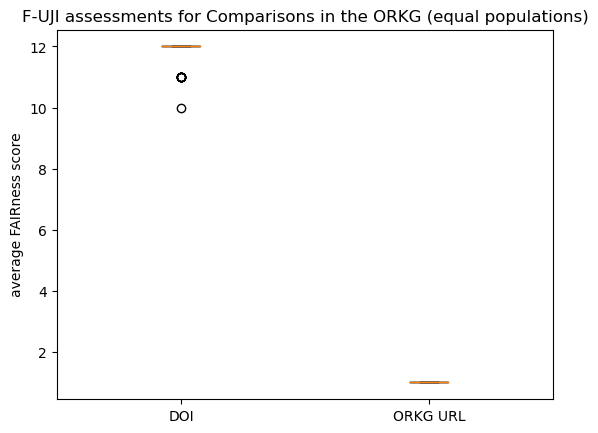

In [54]:
doi_orkg_df = pd.merge(doi_df, orkg_resource_url_df, on=["comparison", "doi"], suffixes=("_doi", "_orkg"))
assessement_data_merged = [doi_orkg_df["score_earned_doi"], doi_orkg_df["score_earned_orkg"]]
plt.boxplot(assessement_data_merged)
plt.title("F-UJI assessments for Comparisons in the ORKG (equal populations)")
locs, labels = plt.xticks()
plt.xticks(locs, ["DOI", "ORKG URL"])
plt.ylabel("average FAIRness score")
plt.show()

# Resources

In [55]:
def expand_resource_df(df):
    df_exp = pd.DataFrame()
    df_exp["resource"] = list(chain.from_iterable([[x]*16 for x in df["resources"]]))
    df_exp["type_rsrc"] = list(chain.from_iterable([[x]*16 for x in df["type_rsrc"]]))
    df_exp["type_other"] = list(chain.from_iterable([[x]*16 for x in df["type_other"]]))
    df_exp["metric"] = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in df["assessment_summary"]]))
    df_exp["score_earned"] = list(chain.from_iterable([get_earned_scores_from_result(assessment_result=x) for x in df["assessment_summary"]]))
    df_exp["score_total"] = list(chain.from_iterable([get_total_scores_from_result(assessment_result=x) for x in df["assessment_summary"]]))
    return df_exp

## Resource assessment

In [56]:
%%script false --no-raise-error
resource_df = pd.read_csv("raw_data/resource_query_result_2023-04-05.csv")
resource_rsrc_df = resource_df[resource_df["type"].str.endswith("Resource")]
resource_others_df = resource_df[np.logical_not(resource_df["type"].str.endswith("Resource"))]
resource_df = pd.merge(resource_rsrc_df, resource_others_df, on="resources", how="outer", suffixes=("_rsrc", "_other"))
resource_df = resource_df[np.logical_not(resource_df["type_other"].str.endswith("Paper") | resource_df["type_other"].str.endswith("Comparison"))].reset_index(drop=True)
resource_df = resource_df.sample(n=3000, random_state=13)
resource_df = resource_df.reset_index(drop=True)
count = 0
resource_df["assessment_summary"] = resource_df["resources"].map(lambda x: get_assessment(x))
resource_df = resource_df[resource_df["assessment_summary"].isna() == False]
resource_df_assessed = expand_resource_df(resource_df)
resource_df_assessed.to_csv("assessed_data/resource_df_F-UJI_assessment.csv")
resource_df_assessed

Couldn't find program: 'false'


## Resource evaluation + visualizations

In [57]:
resource_df_assessed = pd.read_csv("assessed_data/resource_df_F-UJI_assessment.csv", index_col=0)
resource_df_assessed

,resource,type_rsrc,type_other,metric,score_earned,score_total
0,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,FsF-F1-01D,1,1
1,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,FsF-F1-02D,0,1
2,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,FsF-F2-01M,0,2
3,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,FsF-F3-01M,0,1
4,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,FsF-F4-01M,0,2
...,...,...,...,...,...,...
47995,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,FsF-R1.2-01M,0,2
47996,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,FsF-R1.3-01M,0,1
47997,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,FsF-R1.3-02D,0,1
47998,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,FsF-A1-03D,0,1


In [58]:
resource_df_FAIR = resource_df_assessed.groupby("resource").agg({"type_rsrc": "first", "type_other": "first", "score_earned": "sum", "score_total": "sum"}).reset_index()
resource_df_FAIR["score_percent"] = resource_df_FAIR.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
resource_df_FAIR

,resource,type_rsrc,type_other,score_earned,score_total,score_percent
0,http://orkg.org/orkg/resource/PWC_02_C23009,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/C23009,1,24,0.041667
1,http://orkg.org/orkg/resource/PWC_0_0046_C23009,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/C23009,1,24,0.041667
2,http://orkg.org/orkg/resource/PWC_0_022_C23009,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/C23009,1,24,0.041667
3,http://orkg.org/orkg/resource/PWC_0_12_C23009,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/C23009,1,24,0.041667
4,http://orkg.org/orkg/resource/PWC_0_90_C23009,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/C23009,1,24,0.041667
...,...,...,...,...,...,...
2983,http://orkg.org/orkg/resource/R78384,http://orkg.org/orkg/class/Resource,None,1,24,0.041667
2984,http://orkg.org/orkg/resource/R78446,http://orkg.org/orkg/class/Resource,None,1,24,0.041667
2985,http://orkg.org/orkg/resource/R78453,http://orkg.org/orkg/class/Resource,None,1,24,0.041667
2986,http://orkg.org/orkg/resource/R78457,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,1,24,0.041667


In [59]:
resource_df_F_A_I_R = resource_df_assessed
resource_df_F_A_I_R["principle"] = resource_df_F_A_I_R["metric"].map(lambda x: get_principle_from_metric(x))
resource_df_F_A_I_R = resource_df_F_A_I_R.groupby("principle").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
resource_df_F_A_I_R["score_earned"] = resource_df_F_A_I_R["score_earned"].map(lambda x: x/len(resource_df_FAIR))
resource_df_F_A_I_R["score_total"] = resource_df_F_A_I_R["score_total"].map(lambda x: x/len(resource_df_FAIR))
resource_df_F_A_I_R["score_percent"] = resource_df_F_A_I_R.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
resource_df_F_A_I_R["principle"] = pd.Categorical(resource_df_F_A_I_R["principle"], ["findable", "accessible", "interoperable", "reusable"])
resource_df_F_A_I_R = resource_df_F_A_I_R.sort_values("principle").reset_index(drop=True)
resource_df_F_A_I_R

,principle,score_earned,score_total,score_percent
0,findable,1.004016,7.028112,0.142857
1,accessible,0.000000,3.012048,0.000000
2,interoperable,0.000000,4.016064,0.000000
3,reusable,0.000000,10.040161,0.000000


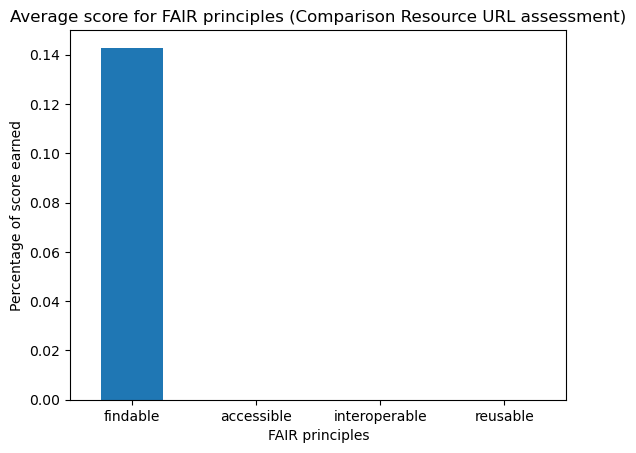

In [60]:
resource_df_F_A_I_R["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["findable", "accessible", "interoperable", "reusable"], rotation=0)
plt.title("Average score for FAIR principles (Comparison Resource URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("FAIR principles")
plt.show()

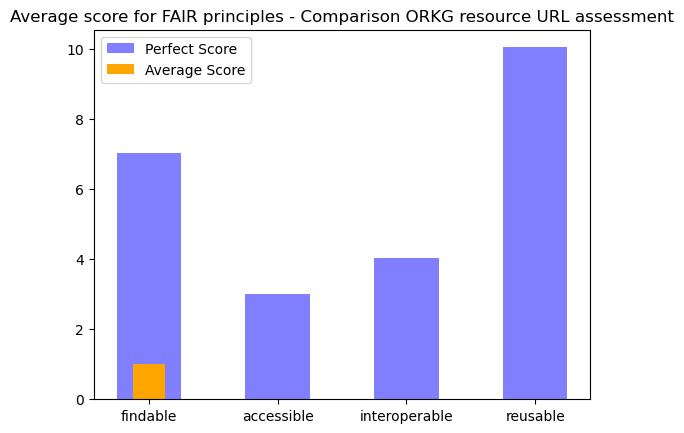

In [61]:
width = 0.5
perfect_scores = resource_df_F_A_I_R["score_total"]
actual_scores = resource_df_F_A_I_R['score_earned']
indices = np.arange(len(resource_df_F_A_I_R['principle']))
plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, resource_df_F_A_I_R['principle'] )
plt.title("Average score for FAIR principles - Comparison ORKG resource URL assessment")
plt.legend()
plt.show()

In [62]:
resource_df_submetrics = resource_df_assessed
resource_df_submetrics = resource_df_submetrics.groupby("metric").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
resource_df_submetrics["score_earned"] = resource_df_submetrics["score_earned"].map(lambda x: x/len(resource_df_FAIR))
resource_df_submetrics["score_total"] = resource_df_submetrics["score_total"].map(lambda x: x/len(resource_df_FAIR))
resource_df_submetrics["score_percent"] = resource_df_submetrics.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
resource_df_submetrics["metric"] = pd.Categorical(resource_df_submetrics["metric"], ["FsF-F1-01D", "FsF-F1-02D", "FsF-F2-01M", "FsF-F3-01M", "FsF-F4-01M", "FsF-A1-01M", "FsF-A1-02M", "FsF-A1-03D", "FsF-I1-01M", "FsF-I2-01M", "FsF-I3-01M", "FsF-R1-01MD", "FsF-R1.1-01M", "FsF-R1.2-01M", "FsF-R1.3-01M", "FsF-R1.3-02D"])
resource_df_submetrics = resource_df_submetrics.sort_values("metric").reset_index(drop=True)
resource_df_submetrics

,metric,score_earned,score_total,score_percent
0,FsF-F1-01D,1.004016,1.004016,1.0
1,FsF-F1-02D,0.000000,1.004016,0.0
2,FsF-F2-01M,0.000000,2.008032,0.0
3,FsF-F3-01M,0.000000,1.004016,0.0
4,FsF-F4-01M,0.000000,2.008032,0.0
5,FsF-A1-01M,0.000000,1.004016,0.0
6,FsF-A1-02M,0.000000,1.004016,0.0
7,FsF-A1-03D,0.000000,1.004016,0.0
8,FsF-I1-01M,0.000000,2.008032,0.0
9,FsF-I2-01M,0.000000,1.004016,0.0


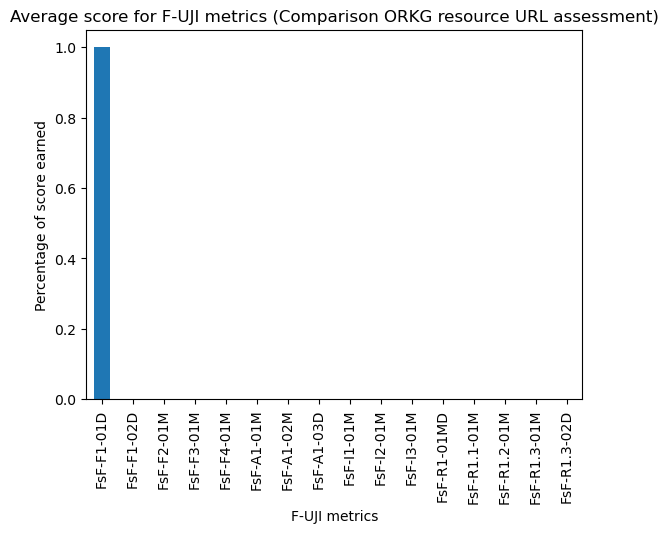

In [63]:
resource_df_submetrics["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["FsF-F1-01D", "FsF-F1-02D", "FsF-F2-01M", "FsF-F3-01M", "FsF-F4-01M", "FsF-A1-01M", "FsF-A1-02M", "FsF-A1-03D", "FsF-I1-01M", "FsF-I2-01M", "FsF-I3-01M", "FsF-R1-01MD", "FsF-R1.1-01M", "FsF-R1.2-01M", "FsF-R1.3-01M", "FsF-R1.3-02D"])
plt.title("Average score for F-UJI metrics (Comparison ORKG resource URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("F-UJI metrics")
plt.show()